# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from scipy.integrate import solve_ivp
from matplotlib import colors
from scipy.signal import find_peaks
from scipy.stats import pearsonr

import HD_utils.circular_stats as cstat
from HD_utils.network import *
from HD_utils.matrix import *
from HD_utils.adap_sim_move import *
from HD_utils.adap_sim_stable import *
from HD_utils.IO import *
from HD_utils.plot import *
from HD_utils.comput_property import *
from HD_utils.exam import *

In [2]:
# Simulation theta precision
theta_num = 50
dtheta = (2*np.pi)/theta_num
theta_range = np.arange(-np.pi+dtheta/2, np.pi, dtheta) # must use np.arange(-np.pi+dtheta/2, np.pi, dtheta) to make it symmetry
# Changeable parameters
ring_num = 2
actfun = max0x
weight_fun = cos_weight3
search_pars = {'JI': np.linspace(-100,0,11), 'JE': np.linspace(0,100,11), 'K0': np.linspace(-100,80,10)}
file_pre_name = '65_2_3'
# Default parameters
inputs = np.array([-1, -0.6, -0.3, -0.1, 0, 0.1, 0.3, 0.6, 1])
net_diff_equa = net_diff_equa_f_in
phi = np.pi * 1/9
tau = 20 # ms
b0 = 1
# Generated parameters
par_num = len(search_pars)
search_num = len(ParameterGrid(search_pars))
zeroid = np.where(inputs == 0)[0][0]
par_names = list(search_pars.keys())

# Load Data

In [ ]:
# Load data after running the current notebook once

# network_evals, network_evaldes, network_acvs, network_pars, network_ts = load_pickle(
#     ['evals', 'eval_des', 'acvs', 'pars', 'ts'], weight_fun, actfun, file_pre_name)
# valid_index_s = np.where(network_evals == 'valid')[0]
# valids_num = len(valid_index_s)

# Vels, network_eval_moving, network_eval_moving_des, network_acvs_moving, network_ts_moving, network_eval_moving_sum = load_pickle(
#     ['moving_slope', 'moving_eval', 'moving_eval_des', 'moving_acvs', 'moving_ts', 'moving_eval_sum'], weight_fun, actfun, file_pre_name)

# Stable

In [7]:
# ---- Need Change
t_max1 = tau * 10 # value must be bigger than 200, if t > t_max1 & network has a bad shape, end simulation
t_max2 = tau * 50 # if t > t_max2, stop simulation, even though network has a good shape
# Routine
network_acvs = np.zeros(search_num, dtype='object')
network_evals= np.ones(search_num, dtype='U30')
network_evaldes = np.zeros(search_num, dtype='object')
network_pars = np.zeros((search_num, par_num))
network_ts = np.zeros(search_num, dtype='object')

for i, pars in enumerate(tqdm(  list(ParameterGrid(search_pars))  )):
    # --- Need change
    par_list = [pars[par_names[j]] for j in range(par_num)]
    w = weight_fun(*par_list, phi)
    ## Routine
    b = steady_inputb_withb0(b0, 0, theta_num)
    s0 = net_ini(theta_num, theta_range)
    y, t, network_evals[i], network_evaldes[i] = \
        inte_check_sta(net_diff_equa, t_max1, t_max2, s0, w, tau, b, theta_num, actfun)
    # Store values
    network_pars[i] = par_list
    network_acvs[i] = np.array([ y[:theta_num], y[theta_num:] ])
    network_ts[i] = t
# save simulation result
store_pickle([network_evals, network_evaldes, network_acvs, network_pars, network_ts], 
['evals', 'eval_des', 'acvs', 'pars', 'ts'], weight_fun, actfun, file_pre_name)

valid_index_s = np.where(network_evals == 'valid')[0]
valids_num = len(valid_index_s)
print(valids_num)

100%|██████████| 1210/1210 [00:33<00:00, 35.69it/s]

253


# Moving

In [8]:
# Initialize store variables
network_eval_moving = np.zeros(( search_num, len(inputs) ), dtype='U30')
network_eval_moving_sum = np.copy(network_evals)
network_vvcor = np.zeros((search_num, ring_num, 2))
network_acvs_moving = np.zeros((search_num, len(inputs)), dtype='object')
network_ts_moving = np.zeros((search_num, len(inputs)), dtype='object')
Vels = np.zeros((search_num, len(inputs), ring_num)) 

for i in tqdm(valid_index_s):
    # parameters and weight ---- Need Change
    w = weight_fun(*network_pars[i], phi, theta_num, theta_range)
    # Routine
    s1 = np.concatenate( [network_acvs[i][0,:,-1], network_acvs[i][1,:,-1]] ) # Initial state is the stable state in the stationary case
    for ratioi, ratiov in enumerate(inputs):
        # b = produce_inputs_2ring(b0, ratiov, theta_num) 
        b = steady_inputb_increaseb0(b0, ratiov, theta_num, ratio2=0.5)
        ## Compute network dynamics 
        y, t, network_eval_moving[i,ratioi], Vels[i,ratioi] = inte_check_move(
            net_diff_equa, s1, w, tau, b, theta_num, actfun)
        ## Store values
        network_acvs_moving[i,ratioi] = np.array([ y[:theta_num], y[theta_num:] ])
        network_ts_moving[i,ratioi] = t
    ## Examine
    network_eval_moving[i][zeroid] = 'stable moving'
    network_eval_moving_sum[i] = 'valid stationary shape'
    if np.all(network_eval_moving[i] == 'stable moving'):
        network_vvcor[i] = cal_correlation(inputs, Vels[i])
        network_eval_moving_sum[i] = exam_vv_linearity(network_vvcor[i])
## save simulation result
store_pickle([Vels, network_eval_moving, network_vvcor, network_acvs_moving, network_ts_moving, network_eval_moving_sum], 
             ['moving_slope', 'moving_eval', 'moving_eval_des', 'moving_acvs', 'moving_ts', 'moving_eval_sum'], 
             weight_fun, actfun, file_pre_name)

100%|██████████| 253/253 [00:42<00:00,  5.89it/s]


# Examination

In [9]:
valid_index_stable_move = np.where(np.isin(network_eval_moving_sum, ('linear moving', 'mid-linear moving', 'nonlinear moving')))[0]
valid_index_linear_move = np.where(network_eval_moving_sum == 'linear moving')[0]
valid_index_mid_linear_move = np.where(network_eval_moving_sum == 'mid-linear moving')[0]

print('Stable still, Stable moving, Half Linear, Whole Linear')
print(len(valid_index_s), len(valid_index_stable_move), len(valid_index_mid_linear_move), len(valid_index_linear_move))

Stable still, Stable moving, Half Linear, Whole Linear
253 247 22 129


In [10]:
from scipy.stats import linregress
index_cal = valid_index_linear_move

acv = np.zeros((search_num, len(inputs), 4)) # 3rd dim: peaku, meanu, peakf, meanf
slope = np.zeros((search_num, 4))
for i in index_cal:
    for j in range(len(inputs)):
        u = network_acvs_moving[i,j][0,:,-1] + b0 
        f = actfun(u)
        acv[i,j,0] = u.max()
        acv[i,j,1] = u.mean()
        acv[i,j,2] = f.max()
        acv[i,j,3] = f.mean()
    for j in range(4):
        res = linregress(inputs[zeroid:], acv[i,zeroid:,j])
        slope[i,j] = res.slope

print(f'Net num: {len(index_cal)}')
printtitle = ['peak u', 'mean u', 'peak f', 'mean f']
for i in range(4):
    cor_stat = cal_cstat_and_print_65(index_cal, slope[:,i], slope, printtitle=printtitle[i], print_ratio=False)
print('Minimum of all except mean u')
cor_stat = cal_cstat_and_print_65(index_cal, slope[:,[0,2,3]].min(axis=1), slope, printtitle=f'      ', print_ratio=False)

Net num: 129
peak u Slope: +% = 129 (100.0%), +M = 0.605, +SD = 0.281 +MAX = 2.182, -M = nan, -SD = nan
    
mean u Slope: +% =  44 (34.1%), +M = 0.227, +SD = 0.117 +MAX = 0.396, -M = -2.342, -SD = 3.933
    
peak f Slope: +% = 129 (100.0%), +M = 0.605, +SD = 0.281 +MAX = 2.182, -M = nan, -SD = nan
    
mean f Slope: +% = 129 (100.0%), +M = 0.125, +SD = 0.055 +MAX = 0.278, -M = nan, -SD = nan
    
Minimum of all except mean u
       Slope: +% = 129 (100.0%), +M = 0.125, +SD = 0.055 +MAX = 0.278, -M = nan, -SD = nan
    


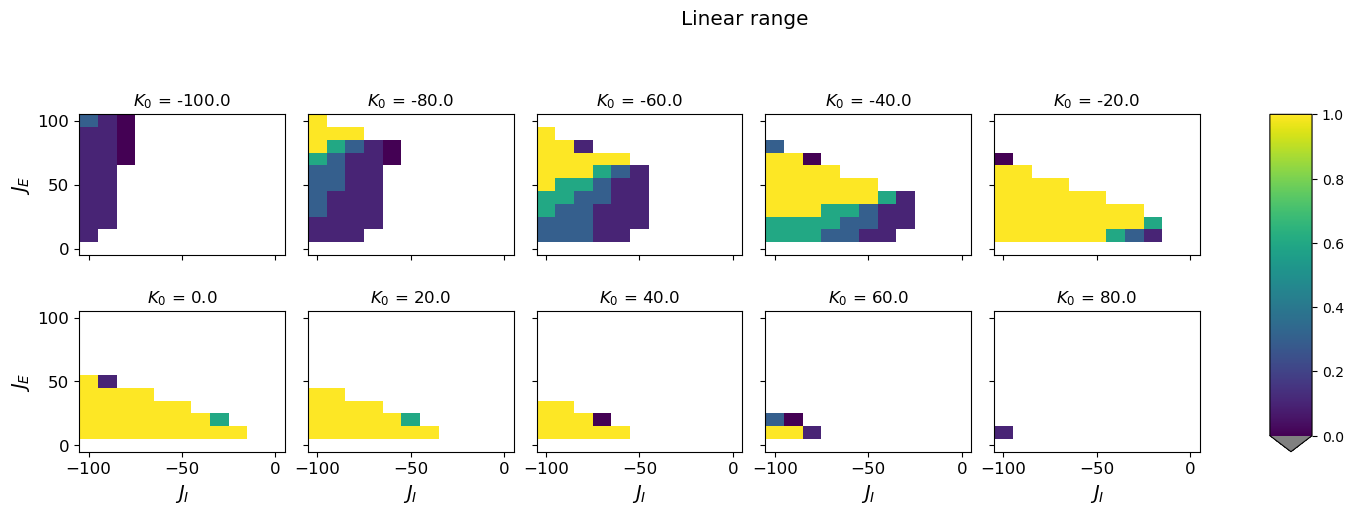

In [11]:
stable_mov_range, stable_mov_range_id, linear_mov_range, linear_mov_range_id = \
    cal_linear_range(network_eval_moving, Vels, inputs, valid_index_s)
linear_range_plot = oned2colormesh_3par(linear_mov_range[:,1], search_pars, network_pars, parnames=['JI','JE','K0'], zero2nan=False)
fig = plot_3par_on_prop(search_pars, linear_range_plot, nrow=2, ncol=5, figsizemag=3, parnames=['JI', 'JE', 'K0'], \
                        figtitle='Linear range\n\n', cmap='viridis', parname_preset=['$J_I$', '$J_E$', '$K_0$'])

In [12]:
index_shape_mismatch, dev_shape_ratios, if_match = cal_lr_shape_match_loop(network_acvs_moving, valid_index_linear_move, zeroid)
print(f'{len(index_shape_mismatch)/len(valid_index_linear_move) * 100:.2f} % = Percent of shape not match')
print(f'{np.mean(dev_shape_ratios):.2e} = Mean[(acv dif) / (max one neighboring acv dif)]')
print(f'{np.std(dev_shape_ratios):.2e} = SD[(acv dif) / (max one neighboring acv dif)]')
print(f'{np.max(dev_shape_ratios):.2e} = Max[(acv dif) / (max one neighboring acv dif)]')

0.00 % = Percent of shape not match
7.18e-06 = Mean[(acv dif) / (max one neighboring acv dif)]
7.58e-05 = SD[(acv dif) / (max one neighboring acv dif)]
4.24e-03 = Max[(acv dif) / (max one neighboring acv dif)]


peak_acv, mean_acv, peak_firate, mean_firate
1.000 = All Mean[Cor: input - RL diff]
0.002 = All SD[Cor: input - RL diff]
0.977 = All Min[Cor: input - RL diff]
0.999 = Mean ACV Mean[Cor: input - RL diff]
0.003 = Mean ACV SD[Cor: input - RL diff]
0.977 = Mean ACV Min[Cor: input - RL diff]


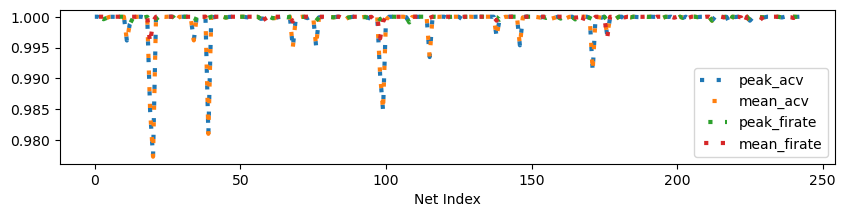

In [13]:
index_n0_linear = np.where( linear_mov_range[:,1] > 0 )[0]
bump_amplitudes = cal_firate_a_acv_mean_a_peak(network_acvs_moving, inputs, valid_index_s, b0, actfun, kind='increaseb0')
input_diff_cors, input_diff_ps = cal_input_diff_cor(inputs, bump_amplitudes[4:], index_n0_linear, linear_mov_range_id)
cor_stat_print_all(input_diff_cors, index_n0_linear)
plot_cor(input_diff_cors, index_n0_linear)